# WORKFLOW for the creation of the ML potentials at Constant Potential

Requirements:

- "Franken" => training and testing of the ML potential
- "LAMMPS" => MD
- "DEAL" python suite + "FLARE" => selection of new configurations
- "VASP" (or alternatively a DFT code) => single-point calculations for the labelling of the configurations 
- "DoubleRefernceMethod" python suite => handling of the DFT workflow

Sequence of STEPS:

0. **STEP 0**: Development of a PZC model (alternatively a pre-trained general-purpose model can be employed) => see notebook "Workflow_PZC.ipynb" 
1. **STEP 1**: Training via Transfer Learning
2. **STEP 2**: Explorative MD simulation with LAMMPS
3. **STEP 3**: "DEAL" selection of new configurations
4. **STEP 4**: Single-point calculations for the labelling of the configurations at constant potential

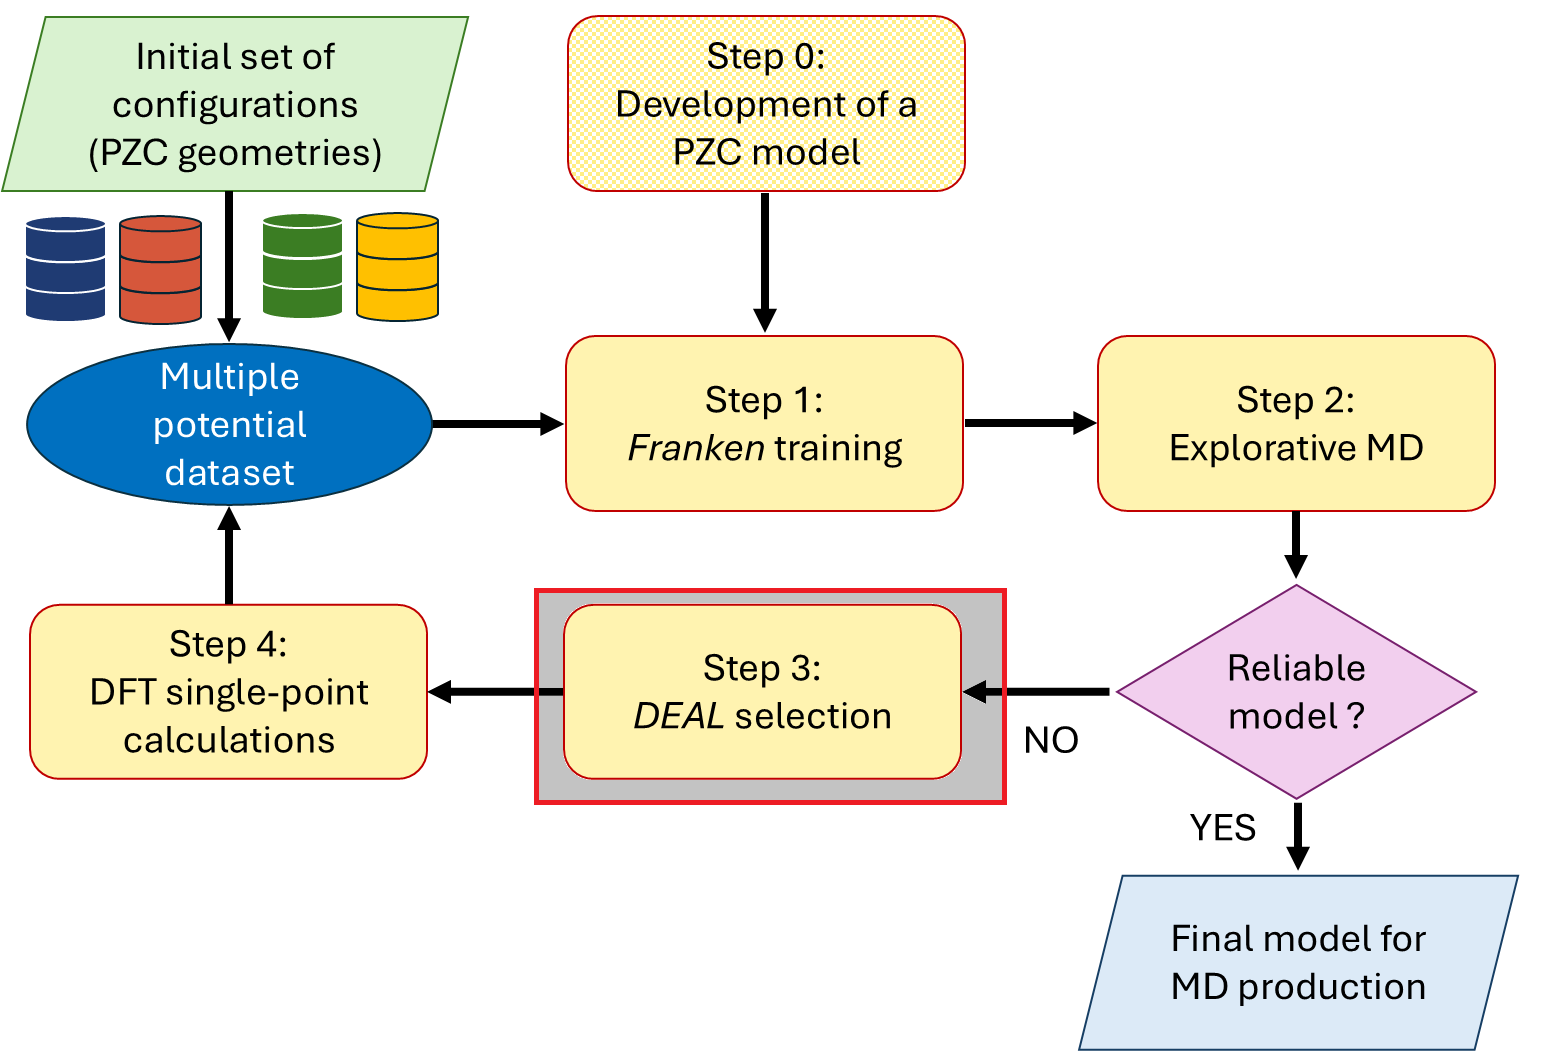

In [1]:
from IPython.display import Image
Image(filename='DEAL/CP_workflow_general_step3.png',width=700, height=600)

These steps should be repeated until the generated ML potentials are sufficiently reliable, i.e.:
- they allow for stable MD simulations
- they are accurate
- they grant converged physical properties (e.g., solvent density profile)

Here we focus on **STEP 3** => "DEAL" selection of new configurations

In [2]:
# Imports:
import numpy as np
import sys
import os
import glob
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
from datetime import datetime

from ase import Atom
from ase.io import read,write

# Path to the workflow_utils directory
# !!! MODIFY IF NEEDED !!!
workflow_utils_path = "../"
sys.path.append(workflow_utils_path)

In [3]:
# SPECIFY the values of target potentials to be used in the calculations
V_vector = [-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0]
V_vector = np.array(V_vector)

print("Target potentials (V vs SHE) to be used in the calculations:\n",V_vector)

from workflow_utils.python_utils import convert_V_to_label

V_vector_labels=convert_V_to_label(V_vector)

print("Corresponding labels for the target potentials:\n",V_vector_labels)

Target potentials (V vs SHE) to be used in the calculations:
 [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
Corresponding labels for the target potentials:
 ['m05', 'm075', 'm1', 'm125', 'm15', 'm175', 'm2']


# STEP 3: "DEAL" selection of new configurations

In [ ]:
# Import DEAL

# !!! Make sure to change the path to the DEAL code folder !!!
path_DEAL_code="/path/to/Deal_code/folder/DEAL/"
sys.path.append(path_DEAL_code)

from deal.input import create_deal_input
from deal.utils import compute_histogram,paletteFessa

Pre-processing

In [5]:
for V in V_vector_labels:
    print(f"Pre-processing for case {V}\n")
    traj=read(f'MD/{V}/Cu_H2O_NVT_{V}.xyz', index=':', format='extxyz')

    # shuffle trajectory
    
    seed = 25 
    idx = [ i for i in range(0,len(traj))]
    np.random.seed(seed)
    np.random.shuffle(idx)

    traj_input = [traj[i] for i in idx]

    # Move traj in DEAL folder

    folder=f"./DEAL/{V}/"
    os.makedirs(folder, exist_ok=True)
    write(folder+'All_Data.xyz',traj_input) 

    print("Done!\n")

Pre-processing for case m05

Done!

Pre-processing for case m075

Done!

Pre-processing for case m1

Done!

Pre-processing for case m125

Done!

Pre-processing for case m15

Done!

Pre-processing for case m175

Done!

Pre-processing for case m2

Done!



DEAL SELECTION

Create input

Paremeters:
* `config_path`: file which contains the default values for descriptors etc.
* `cutoff`: the cutoff for the construction of the local environments (can be a single value or a matrix )
* `deal_threshold`: the threshold for selecting the new structures

In [ ]:
# set DEAL parameters

# The parameters identified in the DEAL step of the PZC workflow can be a good setting also here
cutoffs = [5.5]
deal_thresholds = [0.1]

for V in V_vector_labels:

    print(f"Preparing DEAL input for case {V}")
    
    path_DEAL=f"./DEAL/{V}/"
    for cutoff in cutoffs:
        for deal_threshold in deal_thresholds:
            run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"

            create_deal_input(path_DEAL+'All_Data.xyz',
                            folder=run_folder,
                            config_path=path_DEAL_code+'deal/configs/default.yaml',
                            cutoff = cutoff,
                            threshold = deal_threshold,
                            copy_traj=False) # create a symbolic link in each folder 
            # customize sbatch script template with the correct environment settings
            os.system(f'sed "s+JOBNAME+DEAL_V_{V}+g" DEAL/sbatch_new_deal_template > {run_folder}/sbatch_new_deal')
    
    print("Done!\n")

Preparing DEAL input for case m05
Done!

Preparing DEAL input for case m075
Done!

Preparing DEAL input for case m1
Done!

Preparing DEAL input for case m125
Done!

Preparing DEAL input for case m15
Done!

Preparing DEAL input for case m175
Done!

Preparing DEAL input for case m2
Done!



Run DEAL

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster

for V in V_vector_labels:

    print(f"DEAL job for case {V}")

    path_DEAL=f"./DEAL/{V}/"
    for cutoff in cutoffs:
        for deal_threshold in deal_thresholds:
            run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"
            print(f'Cutoff={cutoff} and threshold={deal_threshold}')
            os.chdir(run_folder)
            os.system("sbatch sbatch_new_deal")   
            os.chdir('../../../../')

Submitting DEAL job for case m05
Submitting DEAL with cutoff=5.5 and threshold=0.1
Submitted batch job 21115003
Submitting DEAL job for case m075
Submitting DEAL with cutoff=5.5 and threshold=0.1
Submitted batch job 21115004
Submitting DEAL job for case m1
Submitting DEAL with cutoff=5.5 and threshold=0.1
Submitted batch job 21115005
Submitting DEAL job for case m125
Submitting DEAL with cutoff=5.5 and threshold=0.1
Submitted batch job 21115006
Submitting DEAL job for case m15
Submitting DEAL with cutoff=5.5 and threshold=0.1
Submitted batch job 21115007
Submitting DEAL job for case m175
Submitting DEAL with cutoff=5.5 and threshold=0.1
Submitted batch job 21115008
Submitting DEAL job for case m2
Submitting DEAL with cutoff=5.5 and threshold=0.1
Submitted batch job 21115009


Results of DEAL for the different potential cases

In [7]:
# Each case has been processed independently

print('DEAL Selection')


for V in V_vector_labels:
    traj_deals = {}
    
    path_DEAL=f"./DEAL/{V}/"
    traj_all = read(path_DEAL+'All_Data.xyz',index=':')
    for cutoff in cutoffs:
        for deal_threshold in deal_thresholds:
            run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"
            traj = read(run_folder+'deal_selected.xyz',index=':')
            traj_deals[cutoff] = traj
            print(f'Case {V}: {len(traj)}/{len(traj_all)} structures')

DEAL Selection
Case m05: 140/1840 structures
Case m075: 137/1832 structures
Case m1: 141/1827 structures
Case m125: 147/1826 structures
Case m15: 144/1827 structures
Case m175: 139/1858 structures
Case m2: 116/1824 structures


# EXTRA

Rather than selecting the geometries independently for each potential case, we observe an improvement in the efficiency of the process by performing a second DEAL selection round, following these steps:

1. performing a DEAL selection of the geometries collected in the previous rounds of active learning ("previous dataset")
2. concatenating and shuffling the selected geometries of each potential case after the first DEAL round
3.  concatenating the selected geometries of step 1. and step 2., making sure that the "previous dataset" geometries are at the beginning of the sequence and not shuffled with the geometries of step 2.
4. performing a second round of DEAL selection on the geometries of step 3.

The rationale of this approach is the selection of fewer new configurations that are not redundant with the configurations already present in the dataset ("previous dataset")


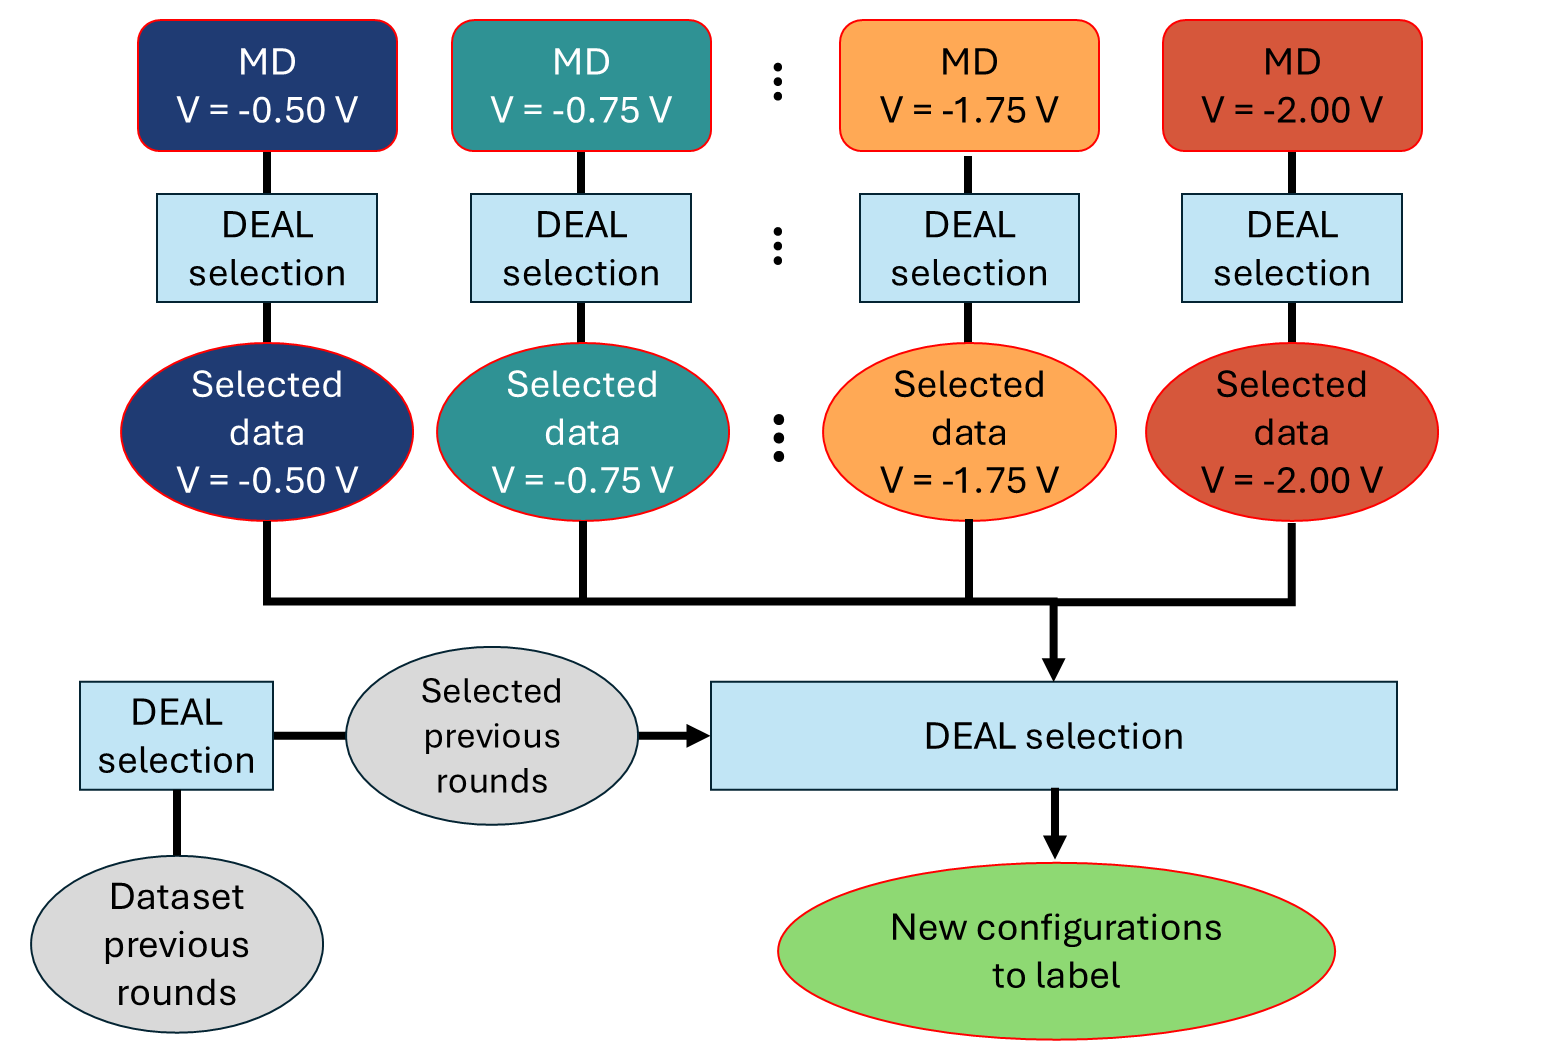

In [8]:
Image(filename='DEAL/DEAL_scheme.png',width=700, height=600)

1. DEAL selection of the geometries collected in the previous rounds of active learning

Pre-processing - previous dataset

In [9]:
path_previous_dataset="Training/Dataset/PZC_label/" # this folder includes all the geometries of the previous active learning cycles 

traj_all = []

for fname in sorted(glob.glob(path_previous_dataset+"*.xyz")): 
    traj = read(fname,index=':') 
    traj_all.extend(traj)
       
# shuffle
np.random.seed(89)
p = np.random.permutation(len(traj_all))
traj_shuffled = [traj_all[i] for i in p] 

# Move traj in DEAL folder
folder=f"./DEAL/previous_dataset/"
os.makedirs(folder, exist_ok=True)
write(folder+'All_Data.xyz',traj_shuffled)

print(f"Previous dataset: {len(traj_shuffled)} configurations")

Previous dataset: 251 configurations


Prepare DEAL input - previous dataset

In [ ]:
cutoff = 5.5
deal_threshold_previous = 0.08

case="previous_dataset"
print("Preparing DEAL input for the dataset of the previous rounds of active learning")

path_DEAL=f"./DEAL/{case}/"
run_folder=path_DEAL+f"threshold-{deal_threshold_previous:.3f}/cutoff-{cutoff}/"

create_deal_input(path_DEAL+'All_Data.xyz',
                folder=run_folder,
                config_path=path_DEAL_code+'deal/configs/default.yaml',
                cutoff = cutoff,
                threshold = deal_threshold_previous,
                copy_traj=False) # create a symbolic link in each folder 
# customize sbatch script template with the correct environment settings
os.system(f'sed "s+JOBNAME+DEAL_{case}+g" DEAL/sbatch_new_deal_template > {run_folder}/sbatch_new_deal')

print("Done!\n")

Preparing DEAL input for the dataset of the previous rounds of active learning
Done!



Run DEAL - previous dataset

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster

print("DEAL job for the dataset of the previous rounds of active learning\n")

path_DEAL=f"./DEAL/{case}/"

run_folder=path_DEAL+f"threshold-{deal_threshold_previous:.3f}/cutoff-{cutoff}/"

os.chdir(run_folder)
os.system("sbatch sbatch_new_deal")   
os.chdir('../../../../')

Submitting DEAL job for the dataset of the previous rounds of active learning

Submitted batch job 21115121


Analysis of DEAL results - previous dataset

In [11]:
print('DEAL Selection')

path_DEAL=f"./DEAL/{case}/"
traj_all = read(path_DEAL+'All_Data.xyz',index=':')

run_folder=path_DEAL+f"threshold-{deal_threshold_previous:.3f}/cutoff-{cutoff}/"
traj = read(run_folder+'deal_selected.xyz',index=':')
print(f'Case {case}: {len(traj)}/{len(traj_all)} structures')

# set a tag equal to 0 for all the selected configurations of the previous dataset to distiguish them from the new configurations

for snap in traj:
    snap.info['tag']=0

write(run_folder+'deal_selected_tag.xyz',traj, format='extxyz')

DEAL Selection
Case previous_dataset: 94/251 structures


2. Concatenating and shuffling the selected geometries of each potential case after the first DEAL round 

In [12]:
traj_all = []
tag_all = []

# Make sure this is the threshold used in the first DEAL selection round when the different potential cases are selected independently
deal_threshold = 0.1

path_original_file_vector=[]

for V,V_format_number in zip(V_vector_labels,V_vector): 

    path_DEAL=f"./DEAL/{V}/"
    run_folder=path_DEAL+f"threshold-{deal_threshold:.3f}/cutoff-{cutoff}/"

    traj = read(run_folder+"deal_selected.xyz",index=':',format='extxyz') 

    print(f"Case {V}: {len(traj)} configurations\n")
        
    # Set tag equal to the potential value
    
    for frame in traj:
        
        frame.info['tag']=V_format_number

        # remove the following tag from the frame
        # This tag is added in the first DEAL round, but it creates inconsistency for the second DEAL round
        del frame.info['target_atoms']
        del frame.info['step']
    traj_all.extend(traj)

# shuffle
np.random.seed(89)
p = np.random.permutation(len(traj_all))
traj_shuffled = [traj_all[i] for i in p] 

# write
input_file="deal_selected_union_V_shuffled.xyz"
write("DEAL/"+input_file,traj_shuffled,format='extxyz') 

Case m05: 140 configurations

Case m075: 137 configurations

Case m1: 141 configurations

Case m125: 147 configurations

Case m15: 144 configurations

Case m175: 139 configurations

Case m2: 116 configurations



3. Concatenating the selected geometries of step 1. and step 2.

In [13]:
path_DEAL_previous=f"./DEAL/previous_dataset/"
run_folder_previous=path_DEAL_previous+f"threshold-{deal_threshold_previous:.3f}/cutoff-{cutoff}/"

# Create folder for the second DEAL round
path_DEAL_2nd="DEAL/2nd_DEAL/"
os.makedirs(path_DEAL_2nd,exist_ok=True)

os.system(f'cat {run_folder_previous}/deal_selected_tag.xyz DEAL/deal_selected_union_V_shuffled.xyz > {path_DEAL_2nd}/All_Data.xyz')

print("End pre-processing - second DEAL round\n")

End pre-processing - second DEAL round



4. Performing a second round of DEAL selection

Prepare DEAL input - second DEAL round

In [ ]:
deal_threshold_bis = 0.1

case="2nd_DEAL"
print(f"Preparing DEAL input for case {case}\n")

run_folder_DEAL_2nd=path_DEAL_2nd+f"threshold-{deal_threshold_bis:.3f}/cutoff-{cutoff}/"

create_deal_input(path_DEAL_2nd+'All_Data.xyz',
                folder=run_folder_DEAL_2nd,
                config_path=path_DEAL_code+'deal/configs/default.yaml',
                cutoff = cutoff,
                threshold = deal_threshold_bis,
                copy_traj=False) # create a symbolic link in each folder 
# customize sbatch script template with the correct environment settings
os.system(f'sed "s+JOBNAME+DEAL_{case}+g" DEAL/sbatch_new_deal_template > {run_folder_DEAL_2nd}/sbatch_new_deal')

print("Done!\n")

Preparing DEAL input for case 2nd_DEAL

Done!



Run DEAL- second DEAL round

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster

print(f"DEAL job for case {case}\n")
os.chdir(run_folder_DEAL_2nd)
os.system("sbatch sbatch_new_deal")   
os.chdir('../../../../')

Submitting DEAL job for case 2nd_DEAL

Submitted batch job 21116686


Analysis of the results - second DEAL round

Number geometries before second DEAL round: 1058
Number geometries selected at the second DEAL round: 147


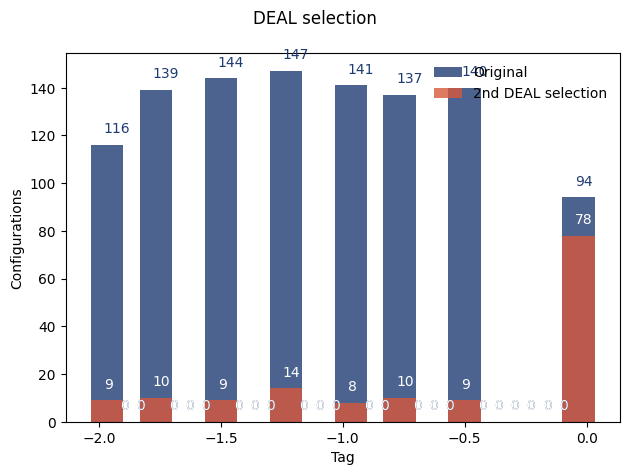

In [ ]:
# Geometries before second DEAL round
dataset_all=read(path_DEAL_2nd+'All_Data.xyz',index=':',format='extxyz')
tag_all=np.ones(len(dataset_all))

for i,snap in enumerate(dataset_all):
    tag_all[i]=snap.info["tag"]

# Geometries selected at the second DEAL round
dataset_selected=read(run_folder_DEAL_2nd+'deal_selected.xyz',index=':',format='extxyz')
tag_selected=np.ones(len(dataset_selected))

for i,snap in enumerate(dataset_selected):
    tag_selected[i]=snap.info["tag"]

print(f'Number geometries before second DEAL round: {len(dataset_all)}')
print(f'Number geometries selected at the second DEAL round: {len(dataset_selected)}')

# Plot selection vs tag of the applied potential case
# Remember a tag = 0 means that it is a geometry of the previous dataset

fig, ax = plt.subplots(dpi=100,sharex=True,sharey=True)
bins_cv=10
x,h = compute_histogram(tag_all,bins=bins_cv)
dx=x[1]-x[0]
ax.bar(x,h,width=dx/0.5,label=f'Original',alpha=0.8,color='fessa0',zorder=0)
for xi,hi in zip(x,h):
    ax.text(xi-dx/5,hi+5,f'{hi}',color='fessa0')

x,h = compute_histogram(tag_selected,bins=bins_cv)
dx=x[1]-x[0]
ax.bar(x,h,width=dx/0.5,label='2nd DEAL selection',alpha=0.8,color='fessa6',zorder=1)
for xi,hi in zip(x,h):
    ax.text(xi-dx/5,hi+5,f'{hi}',color='w')

ax.set_xlabel('Tag')
ax.set_ylabel('Configurations')
ax.legend(frameon=False)

plt.suptitle('DEAL selection')
plt.tight_layout()
plt.show()

# Notice in this tutorial, we have selected few configurations. 
# In real case scenarios, more configurations could be selected lowering the deal thresholds.

Create the POSCAR files for the DFT labelling of the selected configurations

In [16]:
dataset_selected=read(run_folder_DEAL_2nd+'deal_selected.xyz',index=':',format='extxyz')

for V,V_format_number in zip(V_vector_labels,V_vector): 

    poscar_folder=f"DEAL/POSCAR_temp/{V}/"
    os.makedirs(poscar_folder,exist_ok=True)
    counter_configuration=0

    for i,snap in enumerate(dataset_selected):
        
        # Distinguish among the different potential cases
        if snap.info["tag"]==V_format_number:
    
            write(poscar_folder+f'POSCAR_{counter_configuration}',snap,format='vasp')
            counter_configuration=counter_configuration+1

    print(f"Total number of configurations for case {V}: {counter_configuration}")

Total number of configurations for case m05: 9
Total number of configurations for case m075: 10
Total number of configurations for case m1: 8
Total number of configurations for case m125: 14
Total number of configurations for case m15: 9
Total number of configurations for case m175: 10
Total number of configurations for case m2: 9
